In [1]:
import argparse
import io
import sys
from collections import Counter
import emoji
import pandas as pd
import re
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from matplotlib.font_manager import FontProperties

# Load Apple Color Emoji font 
prop = FontProperties(fname='/System/Library/Fonts/Apple Color Emoji.ttc')

# imported from current directory
from chatline import Chatline
from font_color import Color

In [2]:
"""
CLI Set in Jupyter Notebook
"""
# Uncomment to take inputs from user in the notebook
#chatfile = input("Please input the chat filepath:")
#stopword = input("Please input the stopword file:")
#customstopword = input("Please input the custom stopword filepath:")

chatfile = "_chat.txt"
stopword = "english"
customstopword = "customstopwords.txt"

In [3]:
"""
READ FILE
"""
try:
    with io.open(chatfile, "r", encoding="utf-8") as file:
        lines = file.readlines()
    
except IOError as e:
    print("File \"" + chatfile + "\" not found. Please recheck your file location")
    sys.exit()

stop_words = []
if stopword:
    try:
        with io.open("stop-words/" + stopword + ".txt", "r", encoding="utf-8") as file:
            stop_words = [x.strip() for x in file.readlines()]
    except IOError as e:
        print("Stop Words file not found in \"" + stopword + "\" not found.")
        sys.exit()


if customstopword:
    try:
        with io.open(customstopword, "r", encoding="utf-8") as file:
            stop_words = stop_words + [x.strip() for x in file.readlines()]
    except IOError as e:
        print("Custom Stop Words file not found in \"" + customstopword + "\" not found.")
        sys.exit()


In [79]:
        
"""
PARSING AND COUNTING
"""
chat_counter = {
    'chat_count': 0,
    'deleted_chat_count': 0,
    'event_count': 0,
    'senders': [],
    'timestamps': [],
    'words': [],
    'domains': [],
    'emojis': [],
    'fav_emoji': [],
    'fav_word': []
}

### Create a pandas dataframe
sender = []
message = []
datetime = []
weekday = []
is_following = []
is_deleted = []
line_type = []

previous_line = None
for line in lines:
    chatline = Chatline(line=line, previous_line=previous_line)
    previous_line = chatline

    # Counter
    if chatline.line_type == 'Chat':
        chat_counter['chat_count'] += 1

    if chatline.line_type == 'Event':
        chat_counter['event_count'] += 1

    if chatline.is_deleted_chat:
        chat_counter['deleted_chat_count'] += 1

    if chatline.sender is not None:
        chat_counter['senders'].append(chatline.sender)
        for i in chatline.emojis:
            chat_counter['fav_emoji'].append((chatline.sender, i))
        
        for i in chatline.words:
            chat_counter['fav_word'].append((chatline.sender, i))

    if chatline.timestamp:
        chat_counter['timestamps'].append(chatline.timestamp)

    if len(chatline.words) > 0:
        chat_counter['words'].extend(chatline.words)

    if len(chatline.emojis) > 0:
        chat_counter['emojis'].extend(chatline.emojis)

    if len(chatline.domains) > 0:
        chat_counter['domains'].extend(chatline.domains)

    sender.append(chatline.sender)
    datetime.append(chatline.timestamp)
    weekday.append(chatline.weekday)
    body = chatline.deEmojify(chatline.body)
    message.append(body)
    if chatline.is_followingline:
        is_following.append(True)
    else:
        is_following.append(False)
    if chatline.is_deleted:
        is_deleted.append(True)
    else:
        is_deleted.append(False)
    line_type.append(chatline.line_type)

"""
REDUCE AND ORDER DATA
"""

def reduce_and_sort(data):
    return sorted(
        dict(
            zip(
                Counter(data).keys(), 
                Counter(data).values()
            )
        ).items(), 
        key=lambda x: x[1],
        reverse=True
    )

def reduce_and_filter_words(list_of_words):
    val = [w.lower() for w in list_of_words if (len(w) > 1) and (w.isalnum()) and (not w.isnumeric()) and (w.lower() not in stop_words)]
    return val

def filter_single_word(w):
    return (len(w) > 1) and (w.isalnum()) and (not w.isnumeric()) and (w.lower() not in stop_words)

def reduce_fav_item(data):
    exist = []
    arr = []
    for i in data:
        if i[1] > 0 and not i[0][0] in exist:
            exist.append(i[0][0])
            arr.append(i)
    return arr
    
chat_counter['senders'] = reduce_and_sort(chat_counter['senders'])
chat_counter['words'] = reduce_and_sort(reduce_and_filter_words(chat_counter['words']))
chat_counter['domains'] = reduce_and_sort(chat_counter['domains'])
chat_counter['emojis'] = reduce_and_sort(chat_counter['emojis'])
#chat_counter['timestamps'] = reduce_and_sort([(x.strftime('%A'), x.strftime('%H')) for x in chat_counter['timestamps']])
chat_counter['timestamps'] = reduce_and_sort(chat_counter['timestamps'])
chat_counter['fav_emoji'] = reduce_fav_item(reduce_and_sort(chat_counter['fav_emoji']))
chat_counter['fav_word'] = reduce_fav_item(reduce_and_sort([x for x in chat_counter['fav_word'] if filter_single_word(x[1])]))


In [80]:
"""
DataFrame
"""

chat_per_member_df = pd.DataFrame(chat_counter['senders'], columns=['sender', 'count']).set_index('sender')
words_df = pd.DataFrame(chat_counter['words'], columns=['word', 'count']).set_index('word')
domains_df = pd.DataFrame(chat_counter['domains'], columns=['domain', 'count']).set_index('domain')
emojis_df = pd.DataFrame(chat_counter['emojis'], columns=['emoji', 'count']).set_index('emoji')
timestamp_df = pd.DataFrame(chat_counter['timestamps'], columns=['timestamp', 'count']).set_index('timestamp')
fav_emoji_df = pd.DataFrame(chat_counter['fav_emoji'], columns=['fav_emoji', 'count']).set_index('fav_emoji')
fav_word_df = pd.DataFrame(chat_counter['fav_word'], columns=['fav_word', 'count']).set_index('fav_word')

df = pd.DataFrame(zip(datetime, weekday, sender, message, is_following, is_deleted), columns=['timestamp', 'weekday','sender', 'message', 'is_following', 'is_deleted'])
df = df.convert_dtypes()

## df.to_csv("chatout.csv", encoding='utf-8', index=False, header = True,sep='|')


In [81]:
timestamp_df.head()

,count
timestamp,
2021-01-21 22:25:00,227
2020-09-25 15:03:00,206
2019-09-19 01:11:00,201
2020-10-29 03:48:00,116
2020-10-11 01:45:00,95


In [101]:
timestamp_df.index.min()
timestamp_df.index.max()
timestamp_df.describe()
chat_per_member_df.first_valid_index()
chat_per_member_df.last_valid_index()
grouped_heatmap.head()

day  chat_count
dayofweek hour                  
Thursday  22    5489         261
          1     4075         219
Friday    15    5404         218
Wednesday 22    2570         132
Sunday    1     1830         130

In [58]:
heatmap_df = pd.DataFrame(pd.to_datetime(df['timestamp']))

In [72]:
heatmap_df.head()

,timestamp,day,hour,chat_count,dayofweek
0,2018-06-10 05:40:00,10,5,1,Sunday
1,2018-07-15 13:16:00,15,13,1,Sunday
2,2018-07-15 13:16:00,15,13,1,Sunday
3,2018-07-15 13:16:00,15,13,1,Sunday
4,2018-07-15 13:16:00,15,13,1,Sunday


In [71]:
#heatmap_df.insert(2, "day", heatmap_df['timestamp'].dt.day)
heatmap_df["day"] = heatmap_df['timestamp'].dt.day
heatmap_df["hour"] = heatmap_df['timestamp'].dt.hour
heatmap_df["dayofweek"] = heatmap_df['timestamp'].dt.day_name()
heatmap_df["chat_count"] = 1

In [62]:
heatmap_df.columns

Index(['timestamp', 'day', 'hour', 'chat_count'], dtype='object')

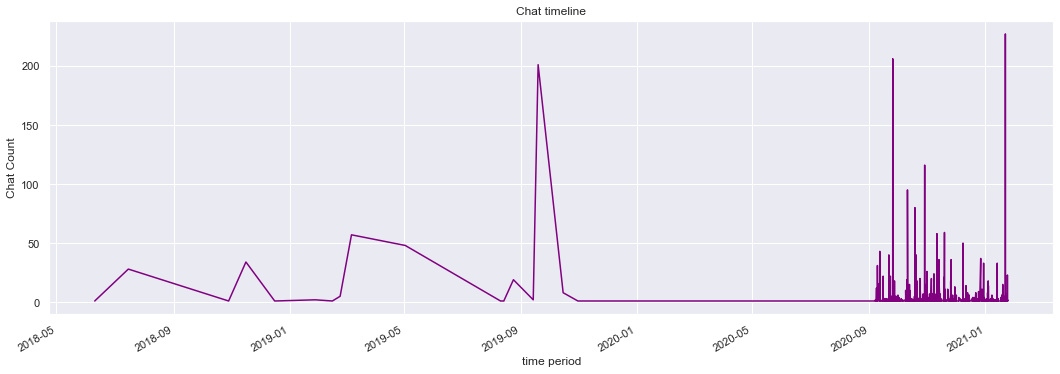

In [83]:
"""
Chat Timeline
"""
if not timestamp_df.empty:
    sns.set()
    member_plot = timestamp_df.plot(kind='line', legend=None, title="Chat timeline", figsize=(18, 6), color="purple")
    member_plot.set_xlabel("time period")
    member_plot.set_ylabel("Chat Count")
else:
    print("This chat has no member")

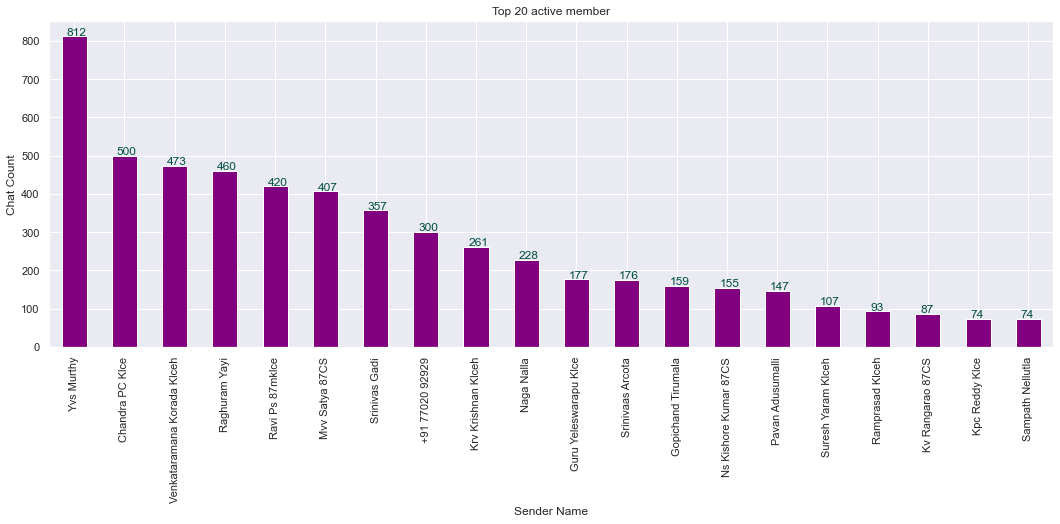

In [7]:
"""
Top Member Chat
"""
top_member = chat_per_member_df.head(20)
if not top_member.empty:
    sns.set()
    member_plot = top_member.plot(kind='bar', legend=None, title="Top 20 active member", figsize=(18, 6), color="purple")
    member_plot.set_xlabel("Sender Name")
    member_plot.set_ylabel("Chat Count")
    for i, v in enumerate(top_member["count"]):
        member_plot.text(i - .15, v + 3, v, color="#004d40")
else:
    print("This chat has no member")

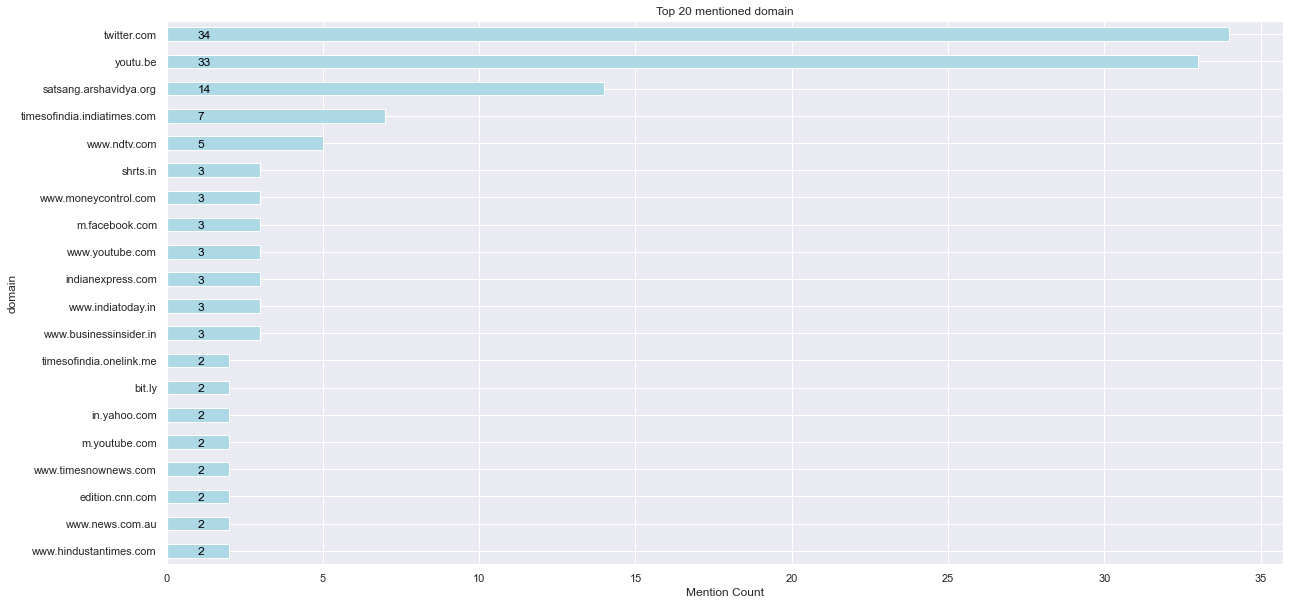

In [8]:
"""
Top Website
"""
top_web = domains_df.head(20).sort_values("count")
if not top_web.empty:
    web_plot = top_web.plot(kind='barh', legend=None, title="Top 20 mentioned domain", figsize=(20,10), color="lightblue")
    web_plot.set_xlabel("Mention Count")
    for i, v in enumerate(top_web["count"]):
        web_plot.text(1, i - .15, v, color="black")
else:
    print("This chat not contains any link")

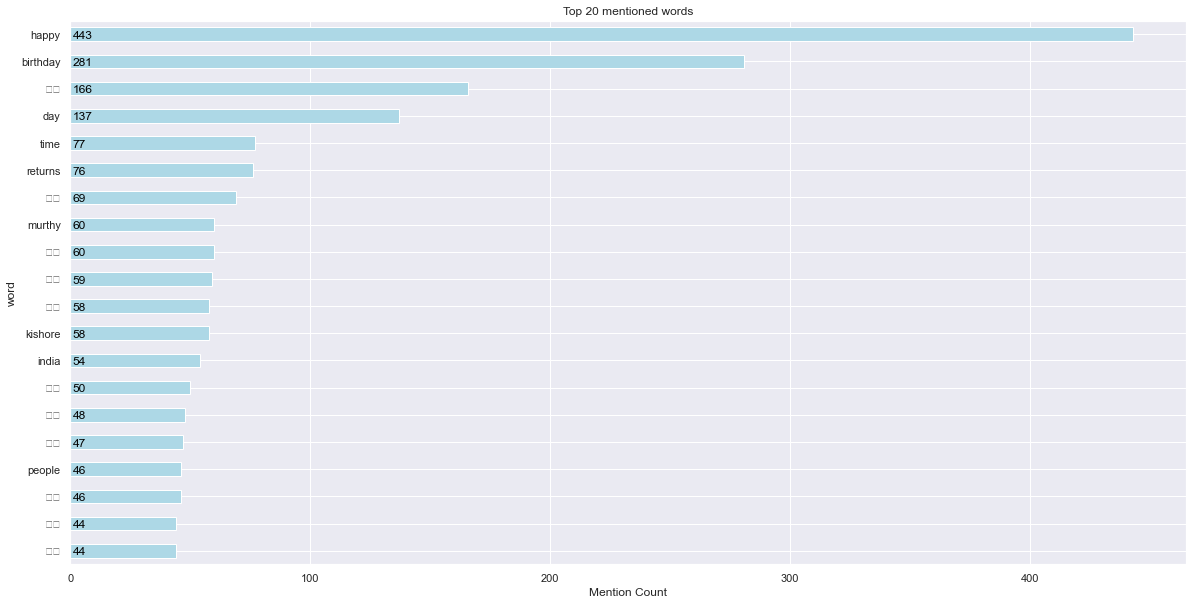

In [9]:
"""
Top words
"""
top_words = words_df.head(20).sort_values("count")
if not top_words.empty:
    word_plot = top_words.plot(kind='barh', legend=None, title="Top 20 mentioned words", figsize=(20,10), color="lightblue")
    word_plot.set_xlabel("Mention Count")
    for i, v in enumerate(top_words["count"]):
        word_plot.text(1, i - .15, v, color="black")
else:
    print("This chat not contains any words")

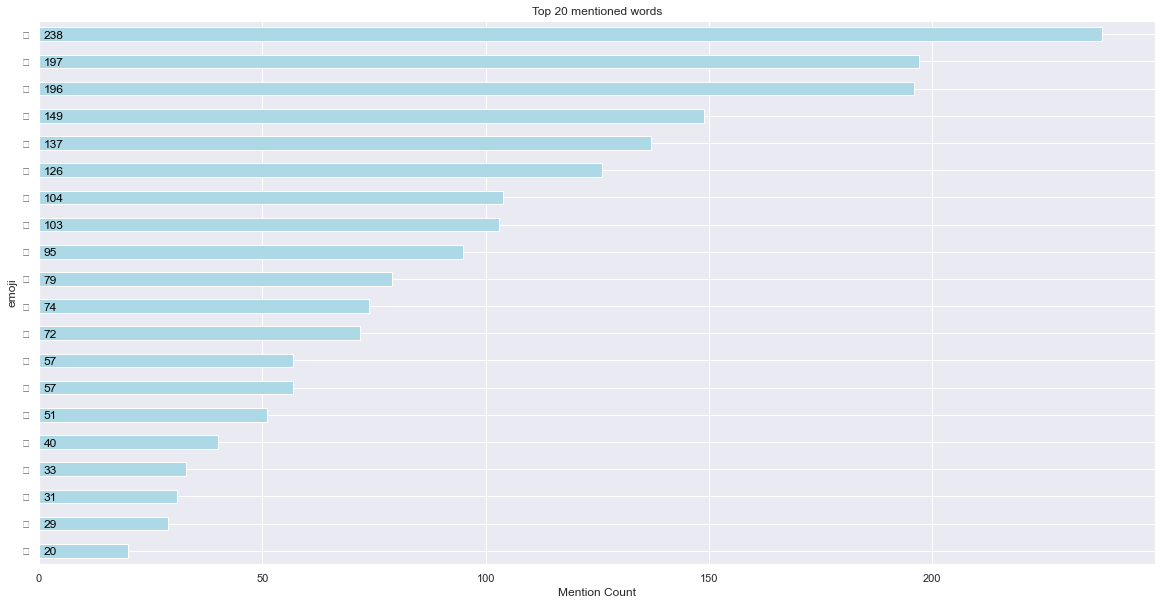

In [10]:
"""
Top emoji
"""
top_emojis = emojis_df.head(20).sort_values("count")
if not top_emojis.empty:
    emoji_plot = top_emojis.plot(kind='barh', legend=None, title="Top 20 mentioned words", figsize=(20,10), color="lightblue")
    emoji_plot.set_xlabel("Mention Count")
    for i, v in enumerate(top_emojis["count"]):
        emoji_plot.text(1, i - .15, v, color="black")
else:
    print("This chat not contains any words")

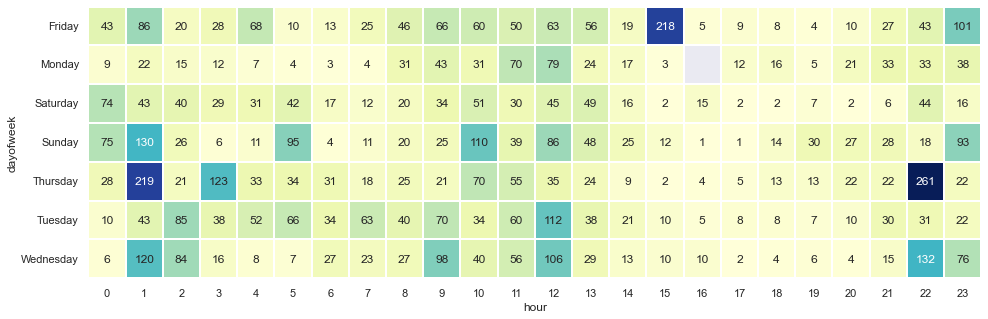

In [76]:
"""
Heatmap
"""
if not heatmap_df.empty:
    grouped_heatmap = heatmap_df.groupby(["dayofweek", "hour"]).sum().sort_values(by=["chat_count"], ascending=False)
    pivoted_heatmap = pd.pivot_table(grouped_heatmap, values='chat_count', index=['dayofweek'], columns=['hour'])
    plt.figure(figsize = (16,5))
    sns.heatmap(pivoted_heatmap, 
                annot=True, 
                fmt=".0f", 
                linewidths=.2,
                cmap="YlGnBu",
                cbar=False
               )
else:
    print("This chat does not contain any datetime")

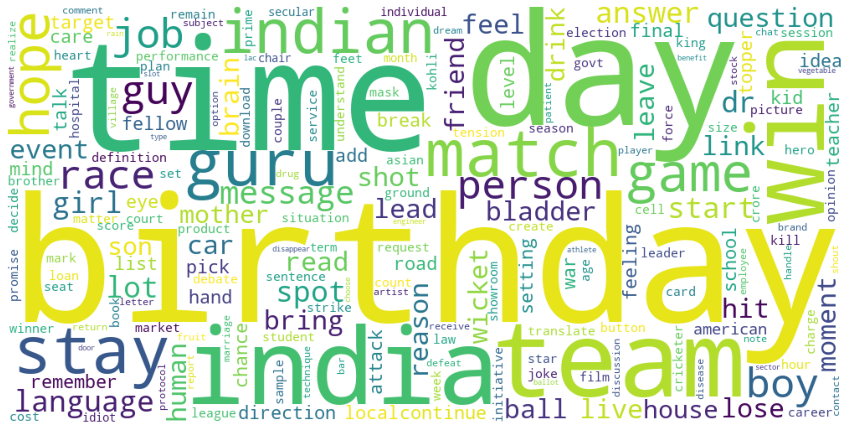

In [11]:
"""
Wordcloud
"""
chat_words = ' '.join([str(word) for word in words_df.index.tolist()])

if chat_words:
    wordcloud = WordCloud(
        width = 1000, 
        height = 500,
        background_color = "white"
    ).generate(chat_words)

    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
else:
    print("This chat contains no word")

In [12]:
"""
RAW Output VISUALIZE
"""
def printBar (value, total, label = '', prefix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    filledLength = int(value / (total / length))
    bar = fill * filledLength + '' * (length - filledLength)
    print("\r{} |{} {}".format(label, bar, Color.bold(str(value))), end = printEnd)
    print()

def printBarChart(data, fill="█"):
    if len(data) <= 0:
        print("Empty data")
        return
    
    total = max([x[1] for x in data])
    max_label_length = len(sorted(data, key=lambda tup: len(tup[0]), reverse=True)[0][0])
    for i in data:
        label = i[0] + " " * (max_label_length - len(i[0]))
        printBar(i[1], total, length=50, fill=fill, label=label)

def printCalendar(data):
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    hours = ['0' + str(x) if len(str(x)) < 2 else str(x) for x in range(24)]

    max_val = float(data[max(data, key=data.get)]) if len(data) else 0

    ticks = [
        0,
        0.25 * max_val,
        0.50 * max_val,
        0.75 * max_val,
    ]

    sys.stdout.write("     ")
    for day in days:
        sys.stdout.write('\t[' + day[:3] + "]")
        
    sys.stdout.write('\n')

    for hour in hours:
        sys.stdout.write("[" + hour + ':00]')
        
        for day in days:
            
            dict_key = (day, hour)
            
            if dict_key in data:
                # tick = str(ct[dict_key])
                
                if data[dict_key] > ticks[3]:
                    tick = Color.custom("███", bold=True, fg_red=True)
                elif data[dict_key] > ticks[2]:
                    tick = Color.custom("▓▓▓", bold=True, fg_orange=True)
                elif data[dict_key] > ticks[1]:
                    tick = Color.custom("▒▒▒", bold=True, fg_green=True)
                else:
                    tick = Color.custom("░░░", bold=True, fg_light_grey=True)
            else:
                tick = Color.custom('===', bold=False, fg_white=True)
            
            sys.stdout.write('\t ' + tick)
        sys.stdout.write('\n')


# Senders
data = chat_counter['senders']
print(Color.red("-" * 50))
print(Color.red("Chat Count by Sender"))
print(Color.red("-" * 50))
print("Active Sender\t:", Color.red("{}".format(len(data))))
print("Total Chat\t:", Color.red("{}".format(sum([x[1] for x in data]))))
print("Average \t:", Color.red("{:.1f} chat per member".format((sum([x[1] for x in data]) / len(data)) if len(data) else 0)))
print()
printBarChart(data[:20], fill=Color.red("█"))
if len(data) > 20:
    print("---")
    print("Other from {} member | {}".format(Color.red(str(len(data[20:]))), Color.red(str(sum([x[1] for x in data[20:]])))))
print()
print()

# Domains
data = chat_counter['domains']
print(Color.blue("-" * 50))
print(Color.blue("Mentioned Domain (Shared Link/URL)"))
print(Color.blue("-" * 50))
print("Domain Count\t: ", Color.blue(str(len(data))))
print("Mention Count\t: ", Color.blue(str(sum([x[1] for x in data]))))
print()
printBarChart(data[:20], fill=Color.blue("█"))
if len(data) > 20:
    print("---")
    print("Other {} domain | {}".format(Color.blue(str(len(data[20:]))), Color.blue(str(sum([x[1] for x in data[20:]])))))
print()
print()


# Emojis
data = [(x[0] + " (" + emoji.demojize(x[0]) + ") ", x[1]) for x in chat_counter['emojis']]
print(Color.orange("-" * 50))
print(Color.orange("Used Emoji"))
print(Color.orange("-" * 50))
print("Unique Emoji\t: ", Color.orange(str(len(data))))
print("Total Count\t: ", Color.orange(str(sum([x[1] for x in data]))))
print()
printBarChart(data[:20], fill=Color.orange("█"))
if len(data) > 20:
    print("---")
    print("Other {} emoji | {}".format(Color.orange(str(len(data[20:]))), Color.orange(str(sum([x[1] for x in data[20:]])))))
print()
print()

# Fav Emojis
data = [(x[0][0] + " | " + x[0][1] + " | (" + emoji.demojize(x[0][1]) + ")", x[1]) for x in chat_counter['fav_emoji']]
print(Color.orange("-" * 50))
print(Color.orange("Favorite Emoji by Member"))
print(Color.orange("-" * 50))
print()
printBarChart(data[:20], fill=Color.orange("█"))
print()
print()

# Words
data = chat_counter['words']
print(Color.green("-" * 50))
print(Color.green("Used Word"))
print(Color.green("-" * 50))
print("Unique Word\t: ", Color.green(str(len(data))))
print("Total Count\t: ", Color.green(str(sum([x[1] for x in data]))))
print()
printBarChart(data[:20], fill=Color.green("█"))
if len(data) > 20:
    print("---")
    print("Other {} word | {}".format(Color.green(str(len(data[20:]))), Color.green(str(sum([x[1] for x in data[20:]])))))
print()
print()

# Fav Word
data = [(x[0][0] + " | " + x[0][1] + " | ", x[1]) for x in chat_counter['fav_word']]
print(Color.green("-" * 50))
print(Color.green("Favorite Word by Member"))
print(Color.green("-" * 50))
print()
printBarChart(data[:20], fill=Color.green("█"))
print()
print()

# Heatmap
data = chat_counter['timestamps']
print(Color.purple("-" * 50))
print(Color.purple("Chat Activity Heatmap"))
print(Color.purple("-" * 50))
if len(data) > 0:
    print("Most Busy\t: {}, at {} ({} chat)".format(
        Color.purple(str(data[0][0][0])), 
        Color.purple(str(data[0][0][1]) + ":00"), 
        Color.purple(str(data[0][1]))))
    print("Most Silence\t: {}, at {} ({} chat)".format(
        Color.purple(str(data[-1][0][0])), 
        Color.purple(str(data[-1][0][1]) + ":00"), 
        Color.purple(str(data[-1][1]))))
print()
print('---')
print('X: Days')
print('Y: Hours')
print('---')
print('Less [{}{}{}{}{}] More'.format(
    Color.custom("===", bold=False), 
    Color.custom("░░░", bold=True, fg_light_grey=True),
    Color.custom("▒▒▒", bold=True, fg_green=True),
    Color.custom("▓▓▓", bold=True, fg_orange=True),
    Color.custom("███", bold=True, fg_red=True)
))
print()
printCalendar(dict(data))

--------------------------------------------------
Chat Count by Sender
--------------------------------------------------
Active Sender	: 54
Total Chat	: 6097
Average 	: 112.9 chat per member

Yvs Murthy                 |██████████████████████████████████████████████████ 812
Chandra PC Klce            |██████████████████████████████ 500
Venkataramana Korada Klceh |█████████████████████████████ 473
Raghuram Yayi              |████████████████████████████ 460
Ravi Ps 87mklce            |█████████████████████████ 420
Mvv Satya 87CS             |█████████████████████████ 407
Srinivas Gadi              |█████████████████████ 357
+91 77020 92929            |██████████████████ 300
Krv Krishnan Klceh         |████████████████ 261
Naga Nalla                 |██████████████ 228
Guru Yeleswarapu Klce      |██████████ 177
Srinivaas Arcota           |██████████ 176
Gopichand Tirumala         |█████████ 159
Ns Kishore Kumar 87CS      |█████████ 155
Pavan Adusumalli           |█████████ 147
Suresh Y

In [102]:
"""
Train a sentiment analyzer using movie opinon data 
"""

from nltk.classify import NaiveBayesClassifier
from nltk.corpus import movie_reviews
import pickle
import nltk.classify.util
import sys
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np


def clean(words):
    return dict([(word, True) for word in words])


negative_ids = movie_reviews.fileids('neg')
positive_ids = movie_reviews.fileids('pos')


negative_features = [(clean(movie_reviews.words(fileids=[f])), 'negative') for f in negative_ids]
positive_features = [(clean(movie_reviews.words(fileids=[f])), 'positive') for f in positive_ids]


negative_cutoff = int(len(negative_features) * 95/100)
positive_cutoff = int(len(positive_features) * 90/100)

train_features = negative_features[:negative_cutoff] + positive_features[:positive_cutoff]
test_features = negative_features[negative_cutoff:] + positive_features[positive_cutoff:]

print('Training on %d data, testing on %d data' % (len(train_features), len(test_features)))
classifier = NaiveBayesClassifier.train(train_features)
print('Training complete')
print('accuracy:', nltk.classify.util.accuracy(classifier, test_features)*100,'%')
classifier.show_most_informative_features()


f = open('model', 'wb')
pickle.dump(classifier, f)
f.close()

Training on 1850 data, testing on 150 data
Training complete
accuracy: 81.33333333333333 %
Most Informative Features
             outstanding = True           positi : negati =     16.4 : 1.0
               ludicrous = True           negati : positi =     13.5 : 1.0
              astounding = True           positi : negati =     13.0 : 1.0
                  avoids = True           positi : negati =     13.0 : 1.0
                 idiotic = True           negati : positi =     12.3 : 1.0
             fascination = True           positi : negati =     11.6 : 1.0
               atrocious = True           negati : positi =     11.1 : 1.0
                  symbol = True           positi : negati =     10.9 : 1.0
                  annual = True           positi : negati =     10.2 : 1.0
                  hudson = True           negati : positi =      9.8 : 1.0


In [103]:
"""
Test sentiment with few samples
"""

f = open('model', 'rb')
classifier = pickle.load(f)
f.close()


sentence="i don't love you "
features = clean(sentence)
print(classifier.classify(features))

sentence="i love you sweetheart "
features = clean(sentence)
print(classifier.classify(features))


sentence="i am not saying that i don't love you"
features = clean(sentence)
print(classifier.classify(features))

sentence="This size of laptop is very bad"
features = clean(sentence)
print(classifier.classify(features))

negative
positive
positive
negative


In [152]:
"""
Calculate opinion of the messages in the chat
"""
opinion={}

##f=open('export_chat.txt','r')
pos,neg=0,0
for line in list(zip(df.sender, df.message)):
    try:
        chat=line[1]
        sender=line[0]
        if opinion.get(sender,None) is None:
            opinion[sender]=[0,0]
        res=classifier.classify(clean(chat))
        if res=='positive':
            pos+=1
            opinion[sender][0]+=1
        else:
            neg+=1
            opinion[sender][1]+=1
    except:
        pass
print("positive: {} \nNegative: {}".format(pos,neg))

opinion_df = pd.DataFrame(opinion).transpose()
opinion_df.columns = ['neg', 'pos']
opinion_df.head()

positive: 1802 
Negative: 4298


,neg,pos
<NA>,0,3
Mvv Satya 87CS,70,337
Raghuram Yayi,170,290
Raju Dahagam 87MKlce,27,15
Krv Krishnan Klceh,69,192


<IPython.core.display.Javascript object>


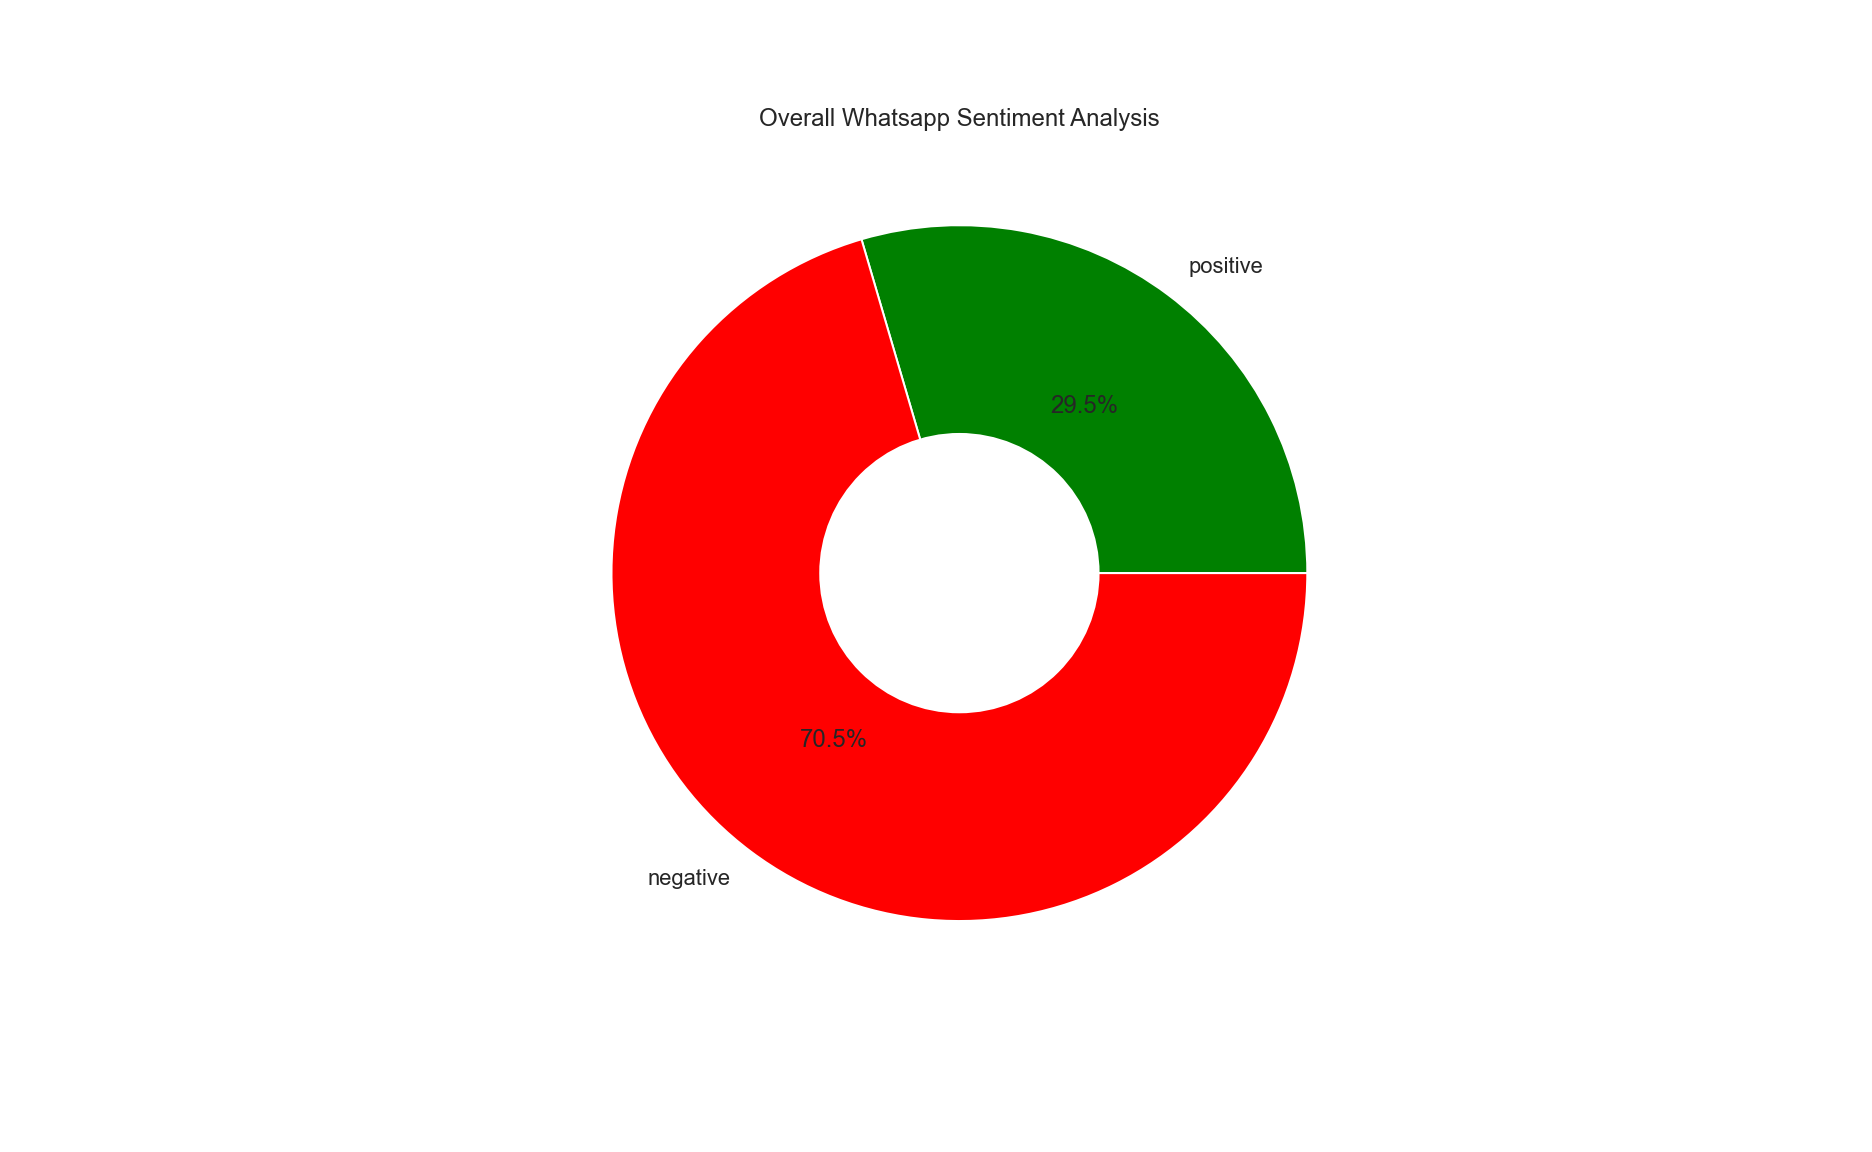

In [155]:
neg=abs(neg)
labels = ['positive','negative']
sizes = [pos,neg]
fig1, ax1 = plt.subplots(figsize=(13,8))
ax1.pie(sizes ,labels=labels, colors=['green','red'], autopct='%1.1f%%')

# draw circle
centre_circle = plt.Circle((0, 0), 0.4, fc='white')
fig = plt.gcf()
  
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)

plt.title('Overall Whatsapp Sentiment Analysis')
plt.show()

<IPython.core.display.Javascript object>


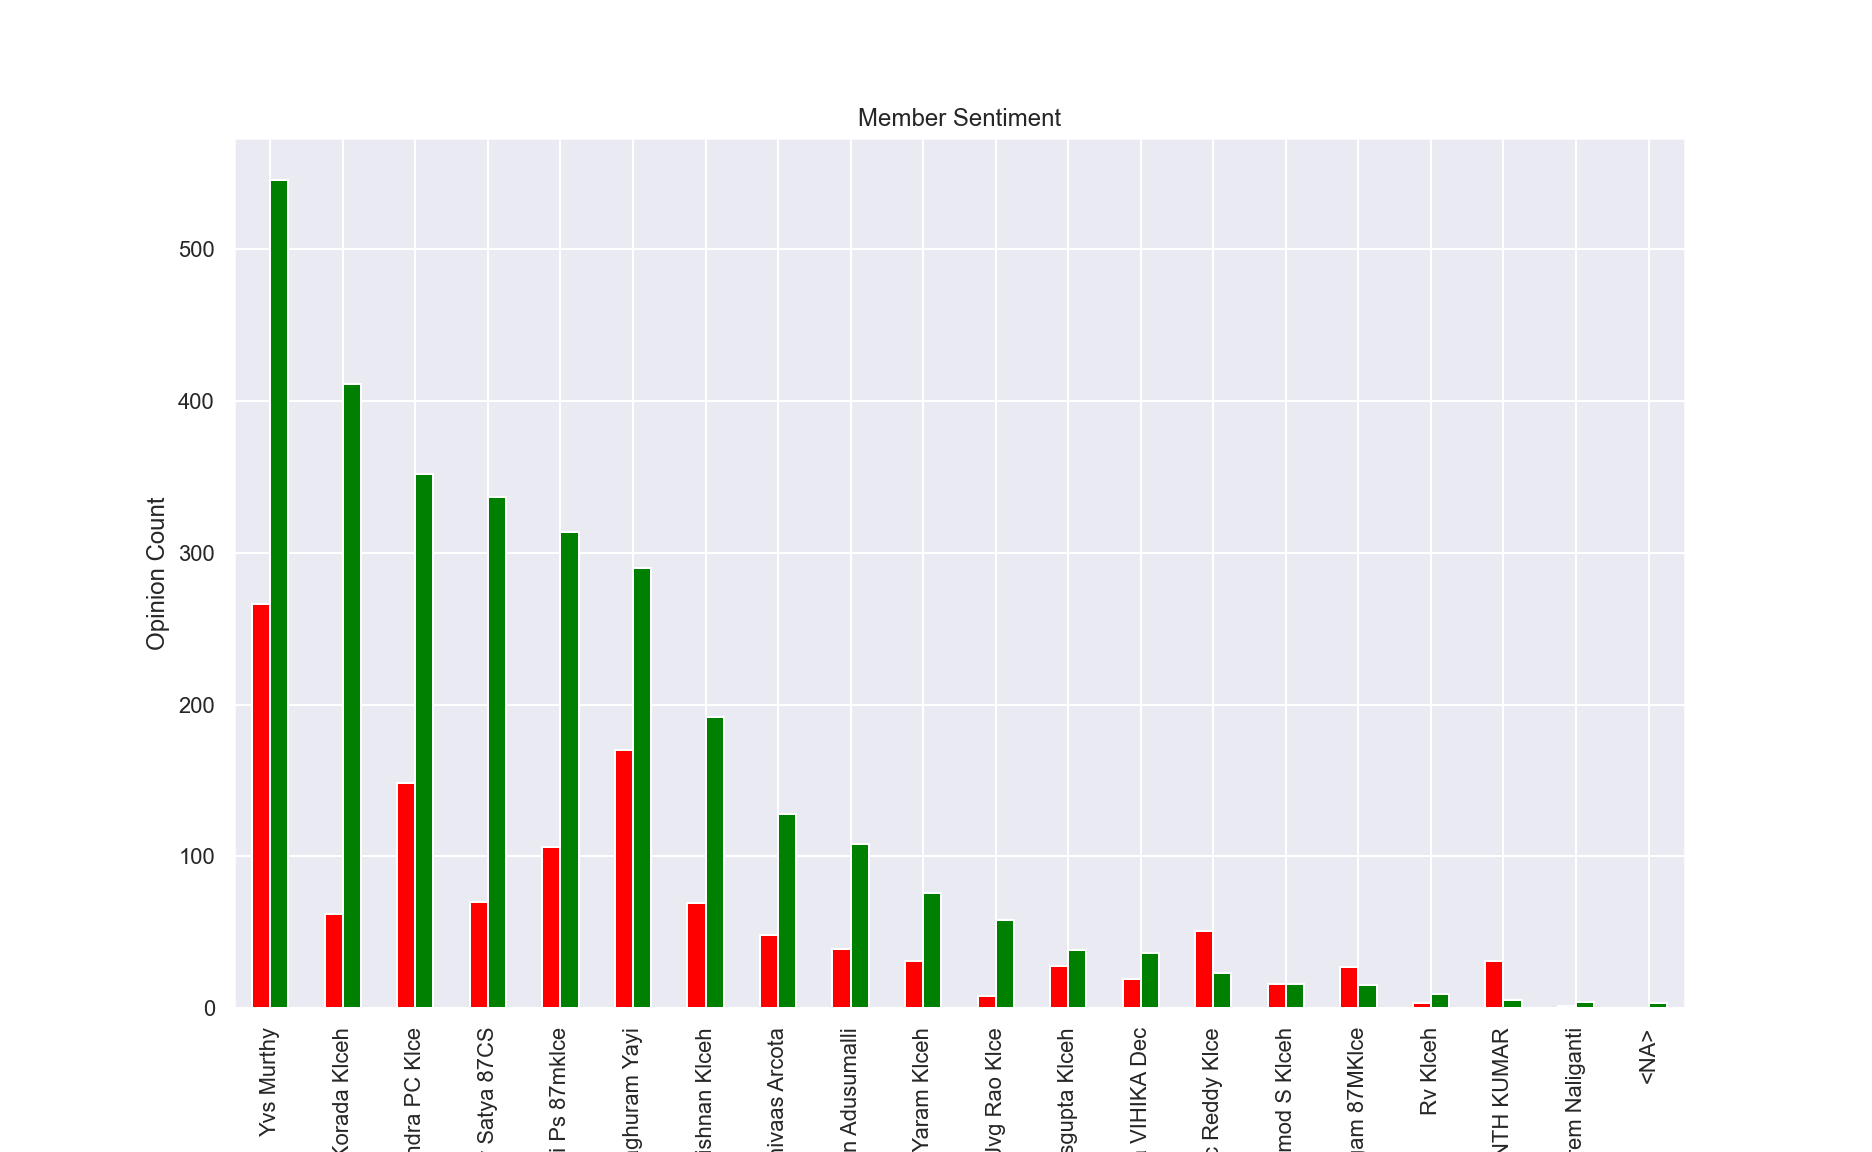

In [154]:
"""
Opinion Analysis
"""
top_opinion = opinion_df.head(20).sort_values(by=['pos', 'neg'], ascending=False)

if not top_opinion.empty:
    sns.set()
    opinion_plot = top_opinion.plot(kind='bar', legend=None, title="Member Sentiment", figsize=(13, 8), color=['red', 'green'])
    opinion_plot.set_xlabel("Sender Name")
    opinion_plot.set_ylabel("Opinion Count")
else:
    print("This chat has no member")